In [2]:
from importlib import reload
import EEG_with_functions as f
reload(f)

import pandas as pd
import numpy as np
from tqdm import tqdm
import mne
import matplotlib.pyplot as plt

import json

In [8]:
positive = [6.7, 6.27, 6.08, 7.07, 6.75, 5.78]
negative = [2.92, 3.02, 3.06, 2.84, 3.29, 2.80]
neutral = [5.20, 5.02, 5.19, 4.90, 4.63, 5.17]
print(np.mean(negative))
print(np.std(negative))
                     

2.9883333333333333
0.16293318330598666


In [4]:
lr = np.load("hyperparam_exps/lr_sweep_tweaked_epochs.npy")
rmse = np.load("hyperparam_exps/lr_sweep_tweaked_RSME.npy")
std = np.load("hyperparam_exps/lr_sweep_tweaked_STD.npy")

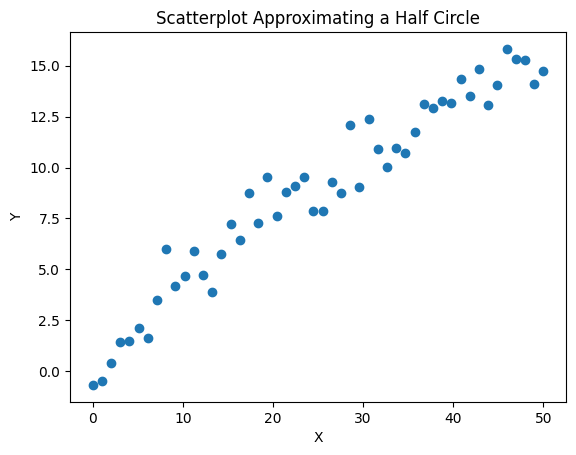

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(0, 50, 50)

# Calculate corresponding y values for a half circle shape
y = 10 * np.sin(x * np.pi / 100) + x / 10

# Add some noise to y values for realism
y += np.random.normal(0, 1, size=y.shape)

# Plot the points in a scatterplot
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot Approximating a Half Circle')
plt.show()




In [23]:
learning_rate_sweep = pd.DataFrame({"Learning rate":lr, "RMSE":rmse, "SD":std})
learning_rate_sweep

,Learning rate,RMSE,SD
0,1.000000,NaN,NaN
1,0.545559,NaN,NaN
2,0.297635,NaN,NaN
3,0.162378,4.445378,1.264176
4,0.088587,4.283536,1.160500
5,0.048329,3.905658,0.957291
6,0.026367,1.976848,0.017605
7,0.014384,1.991322,0.040229
8,0.007848,2.079910,0.106658
9,0.004281,2.167462,0.184804


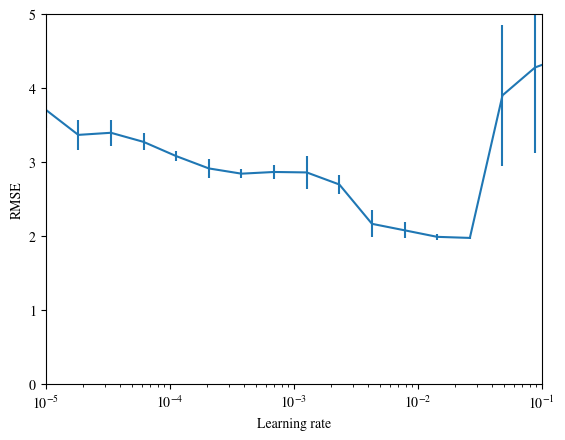

In [17]:
plt.figure()
plt.errorbar(lr, rmse, std)
plt.ylabel("RMSE")
plt.xlabel("Learning rate")
plt.xscale("log")
plt.xlim(1e-5, 0.1)
plt.ylim(0, 5)
plt.savefig('lr_sweep.pdf', format='pdf', bbox_inches = "tight")
plt.show()

# Import, metadata, stim_channels and stimuli names

In [2]:
res = f.import_data("030_1000573.csv", "Sensor_data_compleet", "./")

In [3]:
participant = "30"
info, sampling_freq, n_channels, ch_names, ch_types = f.metadata()
only_electrodes = ch_names
res = f.stim_channels(res)

stimuli_dict, res = f.change_stimuli_names(res)
res, media, stimuli_dict, missing_dict = f.flag_missing_events(res, only_electrodes, stimuli_dict)

c:\Users\scbui\OneDrive\Documents\Master_BMS_PSN\Research_project_2_Unravel\Python\EEG_with_functions.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res2["missing"][i] = "yes"
c:\Users\scbui\OneDrive\Documents\Master_BMS_PSN\Research_project_2_Unravel\Python\EEG_with_functions.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res2["missing"][i] = "no"
c:\Users\scbui\OneDrive\Documents\Master_BMS_PSN\Research_project_2_Unravel\Python\EEG_with_functions.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

In [ ]:
info, channel_names = f.make_mne_object(info, sampling_freq, n_channels, only_electrodes, ch_types)
res = f.remove_nas(res, only_electrodes)
raw = f.convertto_raw(res, channel_names, info)
raw_filter = f.filter_raw(raw)
events, baseline_list, fixcross_list, stimuli_list = f.extract_events(raw_filter)
epochs = f.create_epochs(raw_filter, events, "no")
low_cutoff, high_cutoff, notch_freq, artifact_threshold, n_fft, n_overlap = f.parameters(1.0, 0.1)
# FAA3dim_all_images, spectrum = f.calculate_faa_3dim(epochs, n_overlap, n_fft, 256)
# FAA2dim = f.calculate_faa_2dim(spectrum)

baseline_features_FAA, baseline_epochs = f.baseline_features_FAA(raw_filter, events, fixcross_list, sampling_freq, participant) #LET OP BASELINE LIST OF FIXCROSS LIST
stimuli_features_FAA, stimuli_epochs = f.stimuli_features_FAA(raw_filter, events, stimuli_list, sampling_freq, participant)
baseline_features_psd = f.create_baseline_features_df(events, baseline_epochs, only_electrodes, participant, res, missing_dict)
stimuli_features_psd = f.create_stimuli_features_df(events, stimuli_epochs, only_electrodes, participant, res, missing_dict)

In [ ]:
baseline_features = pd.merge(baseline_features_psd, baseline_features_FAA[["ID", "FAA"]], on = "ID", how = "left")
stimuli_features = pd.merge(stimuli_features_psd, stimuli_features_FAA[["ID", "FAA"]], on = "ID", how = "left")
base_to_stimulus = f.match_bl_to_stimuli(stimuli_dict)
features_individual = f.baseline_correction(baseline_features, stimuli_features)


In [ ]:
# raw_csd = mne.preprocessing.compute_current_source_density(raw_filter)
# raw_filter.plot()
# raw_csd.plot()

In [ ]:
# raw.compute_psd().plot(picks="data", exclude="bads", amplitude=False)
# raw_csd.compute_psd().plot(picks="data", exclude="bads", amplitude=False)

# Create epochs and plot them

194 events found on stim channel cue
Event IDs: [10001 10003 10005 10006 10008 10010 10011 10067 10068 10070 10072 10073
 10129 10130 10132 10134 10135 10191 10192 10194 10196 21002 21007 21069
 21131 21193 22004 22009 22071 22133 22195 30001 30002 30003 30004 30005
 30006 30007 30008 30009 30010 30011 30012 30013 30014 30015 30016 30017
 30018 30019 30020 30021 30022 30023 30024 30025 30026 30027 30028 30029
 30030 30031 30032 30033 30034 30035 30036 30037 30038 30039 30040 30041
 30042 30043 30044 30045 30046 30047 30048 30049 30050 30051 30052 30053
 30054 30055 30056 30057 40002 40005 40009 40011 40013 40054 46001 46003
 46004 46006 46007 46008 46010 46012 46014 46015 46016 46017 46018 46020
 46021 46022 46023 46024 46025 46026 46027 46028 46029 46030 46031 46032
 46033 46034 46035 46036 46037 46039 46040 46041 46042 46043 46044 46045
 46046 46047 46048 46049 46050 46051 46052 46053 46055 46056 50002 50005
 56001 56003 56004 56101 56102 56103 56104 56105 56106 56201 56202 56203
 56

c:\Users\scbui\anaconda3\envs\EEG\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


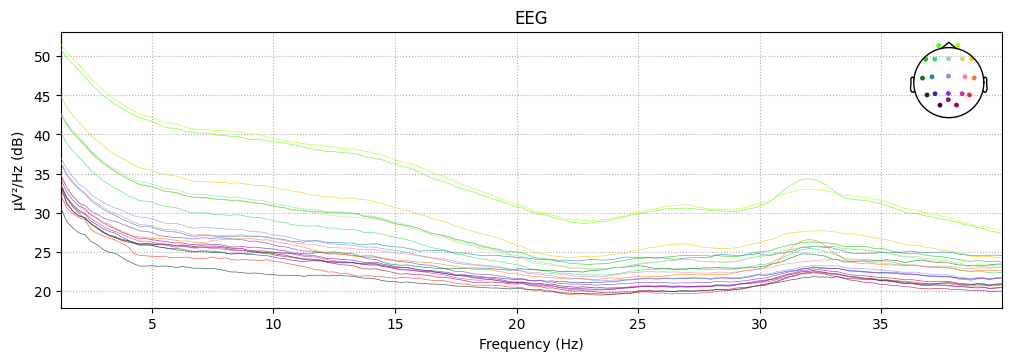

In [ ]:
events, baseline_list, fixcross_list, stimuli_list = f.extract_events(raw_filter)
epochs = f.create_epochs(raw_filter, events, "no")

Fitted sphere radius:         95.5 mm
Origin head coordinates:      -1.0 15.4 45.5 mm
Origin device coordinates:    -1.0 15.4 45.5 mm
No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


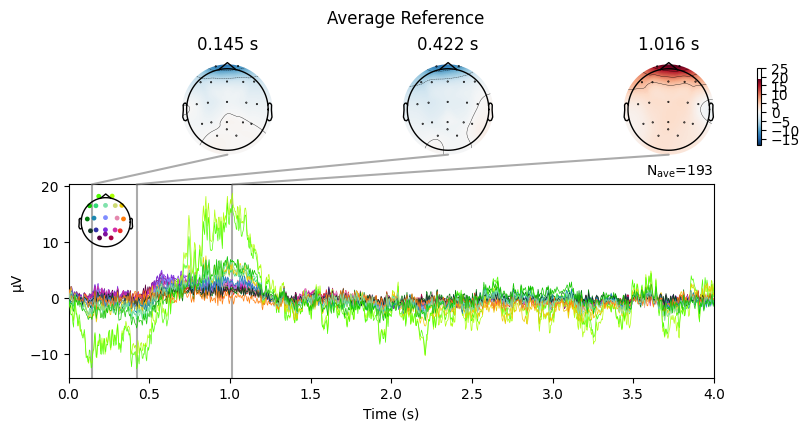

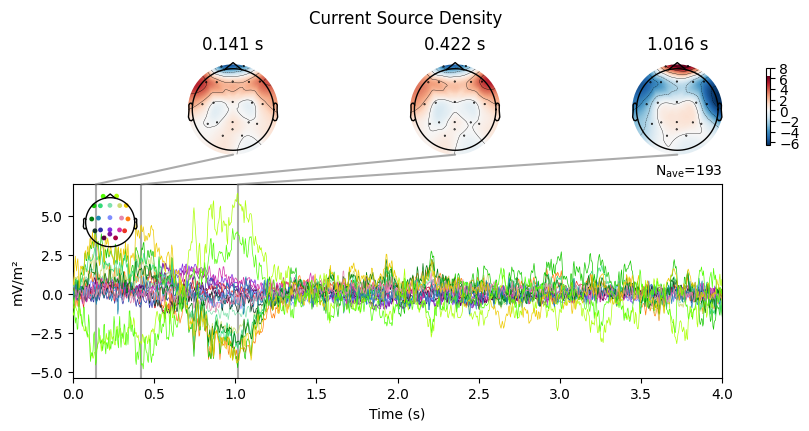

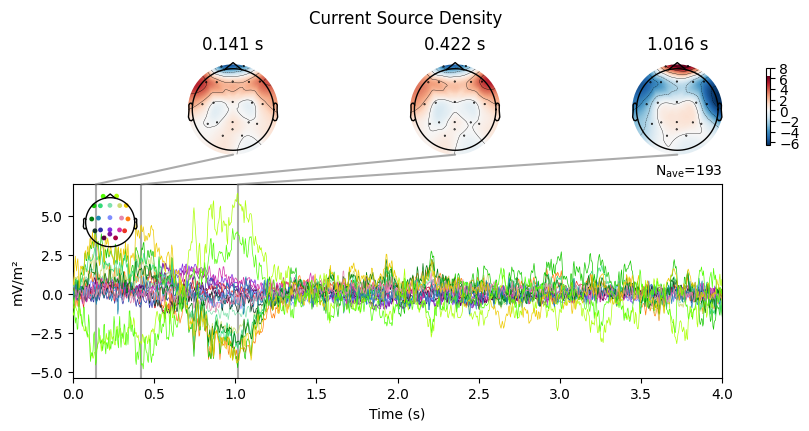

In [ ]:
evoked = epochs.average()
times = np.array([-0.1, 0.0, 0.05, 0.1, 0.15])
evoked_csd = mne.preprocessing.compute_current_source_density(evoked)
evoked.plot_joint(title="Average Reference", show=False)
evoked_csd.plot_joint(title="Current Source Density")

Fitted sphere radius:         95.5 mm
Origin head coordinates:      -1.0 15.4 45.5 mm
Origin device coordinates:    -1.0 15.4 45.5 mm
Fitted sphere radius:         95.5 mm
Origin head coordinates:      -1.0 15.4 45.5 mm
Origin device coordinates:    -1.0 15.4 45.5 mm
Fitted sphere radius:         95.5 mm
Origin head coordinates:      -1.0 15.4 45.5 mm
Origin device coordinates:    -1.0 15.4 45.5 mm
Fitted sphere radius:         95.5 mm
Origin head coordinates:      -1.0 15.4 45.5 mm
Origin device coordinates:    -1.0 15.4 45.5 mm
Fitted sphere radius:         95.5 mm
Origin head coordinates:      -1.0 15.4 45.5 mm
Origin device coordinates:    -1.0 15.4 45.5 mm
Fitted sphere radius:         95.5 mm
Origin head coordinates:      -1.0 15.4 45.5 mm
Origin device coordinates:    -1.0 15.4 45.5 mm
Fitted sphere radius:         95.5 mm
Origin head coordinates:      -1.0 15.4 45.5 mm
Origin device coordinates:    -1.0 15.4 45.5 mm
Fitted sphere radius:         95.5 mm
Origin head coordinates:

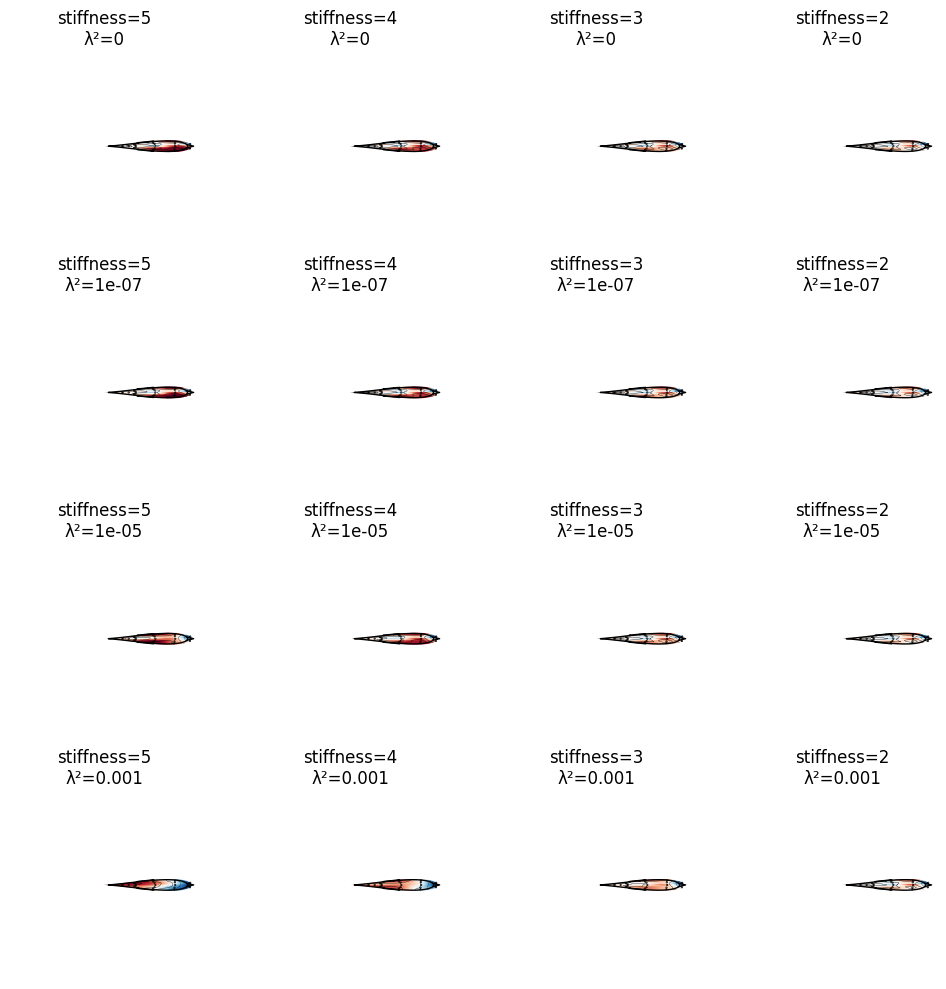

In [ ]:
fig, ax = plt.subplots(4, 4, subplot_kw={'projection': 'polar'})
fig.set_size_inches(10, 10)

for i, lambda2 in enumerate([0, 1e-7, 1e-5, 1e-3]):
    for j, m in enumerate([5, 4, 3, 2]):
        this_evoked_csd = mne.preprocessing.compute_current_source_density(
            evoked, stiffness=m, lambda2=lambda2
        )
        this_evoked_csd.plot_topomap(
            0.1, axes=ax[i, j], contours=4, time_unit="s", colorbar=False, show=False
        )
        ax[i, j].set_title("stiffness=%i\nλ²=%s" % (m, lambda2))

plt.tight_layout()
plt.show()

# Set parameters, calculate FAA and plot spectrum

In [ ]:
low_cutoff, high_cutoff, notch_freq, artifact_threshold, n_fft, n_overlap = f.parameters(1.0, 0.1)

FAA3dim_all_images, spectrum = f.calculate_faa_3dim(epochs, n_overlap, n_fft, 256)
FAA2dim = f.calculate_faa_2dim(spectrum)



Using data from preloaded Raw for 193 events and 1025 original time points ...
Effective window size : 4.004 (s)


In [ ]:
# epochs.plot_sensors(kind="3d", ch_type="all")
# epochs.plot_sensors(kind="topomap", ch_type="all")

## Bereken features en merge de files
Losse df voor baseline en stimuli en
losse df voor FAA en PSD, merge die dan weer

In [ ]:
import EEG_with_functions as f
reload(f)


<module 'EEG_with_functions' from 'c:\\Users\\scbui\\OneDrive\\Documents\\Master_BMS_PSN\\Research_project_2_Unravel\\Python\\EEG_with_functions.py'>

In [ ]:
baseline_features_FAA, baseline_epochs = f.baseline_features_FAA(raw_filter, events, fixcross_list, sampling_freq, "1")
stimuli_features_FAA, stimuli_epochs = f.stimuli_features_FAA(raw_filter, events, stimuli_list, sampling_freq, "1")

Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 54 events and 129 original time points ...
0 bad epochs dropped
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective wind

Media is correct for stim 40002 on row 52374. It shows missing rows though, but these don't fall within the 0.5 * 256 boundries so this baseline could be used.

In [ ]:
media[10:20]

,stim,start,row
10,10011.0,167742.59480,42963
11,30001.0,191336.34480,49009
12,40001.0,195351.96980,50041
13,70005.0,196371.50105,50306
14,30002.0,200394.93855,51341
15,40002.0,204410.56355,52374
16,50006.0,204953.32620,52518
17,30003.0,209019.93855,53565
18,40003.0,212039.46980,54342
19,70004.0,212570.71980,54483


In [ ]:
# baseline_features_psd = f.create_baseline_features_df(events, baseline_epochs, only_electrodes, "1")
baseline_features = pd.DataFrame()
respondent = []
baseline_list = []
baseline_ID = []

for ep in events:
    ep_name = ep[2]

    if str(ep_name).startswith("4") and str(ep_name)[1] != "6": #baseline LET OP: IS NU ALLEEN FIXCROSSES IPV BASELINE, WANT DE BASELINES ZIJN GENOMEN VANAF DE FIXCROSS
        respondent.append("test")
        baseline_list.append("baseline")
        baseline_ID.append(str(ep_name))
        print(ep_name)
        ep_namestr = str(ep_name)
        spectrum_unique = baseline_epochs[ep_namestr].compute_psd(method ="welch", fmin=4, fmax=20) #, n_fft= 256, n_overlap= int(0.1 * 256), n_per_seg = 256

        for ch in only_electrodes:
            for i in range(4, 21):
                hz = spectrum_unique.get_data(fmin=i, fmax=i, picks = ch) #something goes wrong here when including the f.flag_missing_events(res, only_electrodes, stimuli_dict) function???
                print(hz)
                hz_unpacked = hz[0][0][0]
                column = ch + "_" + str(i) + "hz"
                baseline_features.loc[ep_namestr, column]  = float(hz_unpacked)
            

baseline_features["Type"] = baseline_list
baseline_features["ID"] = baseline_ID
baseline_features["Respondent"] = respondent
baseline_features = baseline_features[["Respondent", "ID", "Type"] + [col for col in baseline_features.columns if col not in ["Respondent", "ID", "Type"]]]




40002
Effective window size : 0.504 (s)
[]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:

stimuli_features_psd = f.create_stimuli_features_df(events, stimuli_epochs, only_electrodes, "1")
baseline_features = pd.merge(baseline_features_psd, baseline_features_FAA[["ID", "FAA"]], on = "ID", how = "left")
stimuli_features = pd.merge(stimuli_features_psd, stimuli_features_FAA[["ID", "FAA"]], on = "ID", how = "left")

## Match de baselinenaam aan de stimulusnaam

In [ ]:

base_to_stimulus = f.match_bl_to_stimuli(stimuli_dict)
f.check_names_in_dict(events, base_to_stimulus, "int")


30019 is not in the dict
30038 is not in the dict
30057 is not in the dict


### Baseline correction

In [ ]:
features = f.baseline_correction(baseline_features, stimuli_features)




### Dictionary voor tegenliggende channels

In [ ]:

channel_pairs = {
    "Fp1": "Fp2",
    "F3": "F4",
    "F7": "F8",
    "C3": "C4",
    "T3": "T4",
    "T5": "T6",
    "P3": "P4",
    "O1": "O2",
}


middle_channels = ["Fz", "Cz", "Pz", "Poz"]

# Get the ratings from the survey

In [ ]:
survey = f.import_survey_df()
ratings_dict = f.get_ratings(stimuli_list, survey)
features["mean_rating"] = features["ID"].map(ratings_dict)
features["mean_rating"]

0     3.892308
1     5.492308
2     1.492308
3     3.846154
4     4.138462
5     1.353846
6     2.015385
7     4.569231
8     6.138462
9     4.923077
10    5.953846
11    4.400000
12    2.046154
13    6.307692
14    5.861538
15    2.430769
16    1.738462
17    3.723077
18    1.738462
19    3.892308
20    3.723077
21    3.846154
22    2.015385
23    4.569231
24    5.492308
25    6.307692
26    4.400000
27    5.861538
28    1.492308
29    4.923077
30    6.138462
31    4.138462
32    2.046154
33    2.430769
34    5.953846
35    1.353846
36    4.138462
37    2.015385
38    4.923077
39    4.569231
40    5.861538
41    5.953846
42    5.492308
43    3.723077
44    2.430769
45    2.046154
46    6.307692
47    3.846154
48    3.892308
49    1.353846
50    1.738462
51    1.492308
52    6.138462
53    4.400000
Name: mean_rating, dtype: float64